In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

# Introduction to the Lomb-Scargle Periodogram

**Version 0.2**

* * *

By AA Miller (Northwester/CIERA)  
15 Sep 2021

Today we examine the detection of periodic signals in noisy, irregular data (the standard for ground-based astronomical surveys). 

This lecture is strongly influenced by *Understanding the Lomb-Scarge Periodogram*, by Jake VanderPlas, a former DSFP lecturer [(VanderPlas 2017)](http://adsabs.harvard.edu/abs/2017arXiv170309824V). Beyond that, the original papers by [Lomb 1976](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle 1982](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) are also worth a read.

There are many, many papers on the use of the Lomb-Scargle periodogram (and other period detection methods). A recent study led by former DSFP lecturer, Matthew Graham, conducted a systematic analysis of many of the most popular tools used to search for periodic signals on *actual astronomical data* [(Graham et al. 2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G).$^\dagger$

$^\dagger$Somewhat to my (our?) dismay, they found that none of the solutions work really well across all use cases.

## Problem 1) Helper Functions

We need to simulate and plot the same types of data again and again. To start this lecture we will create a few helper functions to minimize repetitive commands (e.g., phase-folding a light curve). 

**Problem 1a**

Create a function, `gen_periodic_data`, that creates simulated data (including noise) over a grid of user supplied positions:

$$ y = A\,sin\left(\frac{2 \pi x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are inputs to the function. `gen_periodic_data` should include Gaussian noise, $\sigma_y$, for each output $y_i$.

In [2]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*sin(2*pi*x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    A=amplitude
    P=period
    phi=phase
    y = A*np.sin(2*np.pi*x/P-phi)# complete
    dy = np.random.normal(0,np.sqrt(noise),size=len(y))# complete
    return y + dy

**Problem 1b**

Generate a *noise-free* signal with $A = 2$ and $p = \pi$ over a regular grid between 0 and 10. Plot the results (and make sure `gen_periodic_data` behaves as you would expect).

<IPython.core.display.Javascript object>


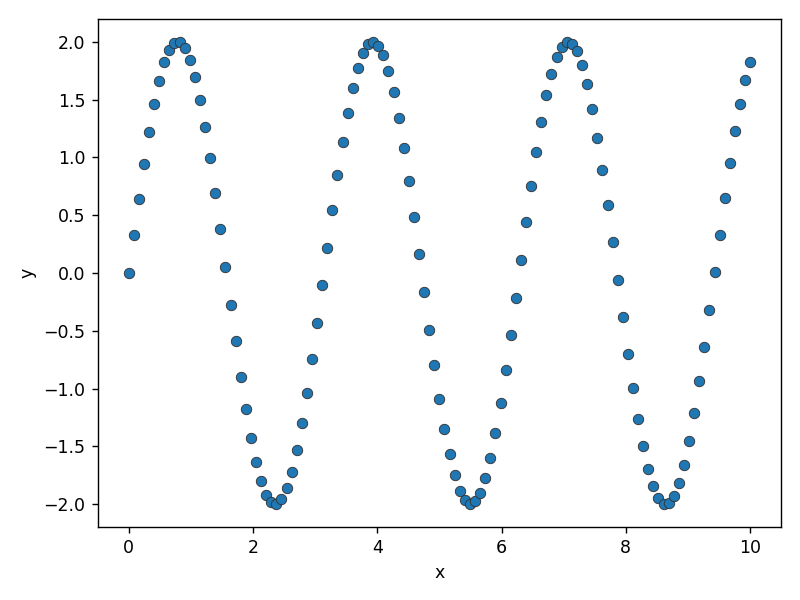

In [3]:
x = np.linspace(0,10,123) # complete
y = gen_periodic_data(x,period=np.pi,amplitude=2) # complete

fig, ax = plt.subplots()
ax.scatter(x,y, edgecolors='0.2', linewidths=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

**Problem 1c**

Create a function, `phase_plot`, that takes x, y, and $P$ as inputs to create a phase-folded light curve (i.e., plot the data at their respective phase values given the period $P$).

Include an optional argument, `y_unc`, to include uncertainties on the `y` values, when available.

In [4]:
def phase_plot(x, y, period, y_unc = 0.0):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1# complete
    if type(y_unc) == float:
        y_unc = np.zeros_like(x)
        
    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    fig.tight_layout()

**Problem 1d**

Plot the phase folded data generated in **1b**.

Does you plot match your expectations?

<IPython.core.display.Javascript object>


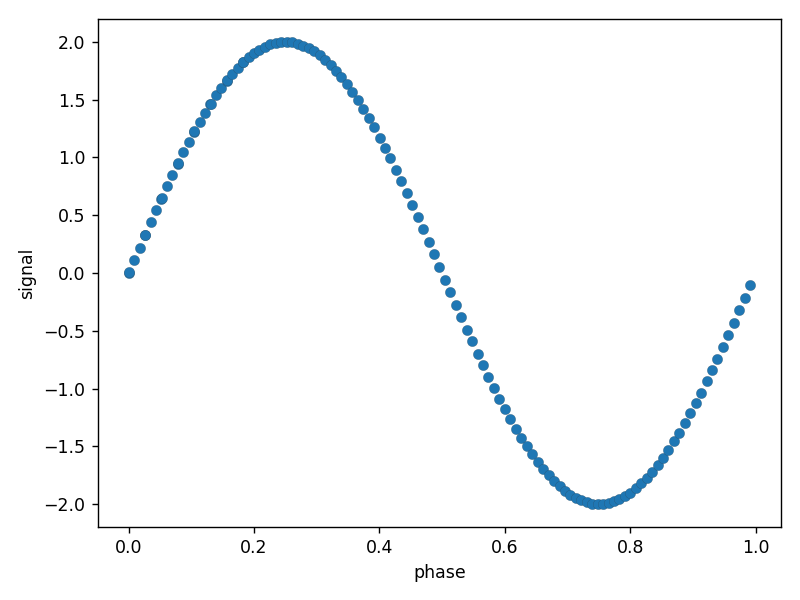

In [5]:
phase_plot(x,y,np.pi) # complete

## Problem 2) A Brief Review of Fourier Analysis

In astronomical time series, we crave the detection of periodic signals because they can often provide fundamental insight into the sources we are studying (e.g., masses in a binary, pulsation timescales in stars, etc).

The standard$^\dagger$ choice for most astronomers to identify such signals is the Lomb-Scargle (LS) periodogram ([Lomb 1976](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L); [Scargle 1982](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)).

$^\dagger$Standard does not mean best, fastest, or even correct depending on your specific application.

At the heart of understanding any periodic signals is Fourier analysis. Thus, to understand how to interpret the LS periodogram, we first need to consider Fourier transforms.

*Note - the following discussion is not complete. See [Lecture I](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Session13#day-1--i-saw-the-sine) from this session for a more thorough review.*

Given a continuous signal, $g(t)$ the Fourier transform of that signal is defined as:

$$\hat{\mathrm{g}}(f) = \int_{-\infty}^{\infty} g(t) \,e^{-2\pi i f t} \,dt,$$

where $i$ is an imaginary number. 

The inverse of this equation is defined as:

$$ g(t) = \int_{-\infty}^{\infty} \hat{\mathrm{g}}(f) \,e^{2\pi i f t} \,df.$$

For convenience, we will use the Fourier transform operator $\mathcal{F}$, from which the previous equations reduce to: 

$$\mathcal{F}(g) = \hat g$$

$$\mathcal{F}^{-1}(\hat{g}) = g$$

There are many useful properties of the Fourier transform including that the Fourier transform is a linear operator. Additionally, a time shift in the signal imparts a phase shift in the transform.

Perhaps most importantly for our present purposes, however, is that the squared amplitude of the resulting transform allows us to get rid of the imaginary component and measure the power spectral density or power spectrum:

$$ \mathcal{P}_g = \left|\mathcal{F}(g)\right|^2.$$

The power spectrum is a real-valued function that quantifies the contribution of each frequency $f$ to the total signal in $g$. The power spectrum thus provides a way to identify the dominant frequency in any given signal. 

Next we consider some common Fourier pairs, that will prove helpful in our interpretation of the LS periodogram. 

In [6]:
fourier_pairs_plot()

NameError: name 'fourier_pairs_plot' is not defined

The common Fourier pairs are especially useful in light of the convolution theorem. Fourier transforms convert convolutions into point-wise products. We define a convolution as:

$$ [f \ast g] (t) = \int_{-\infty}^{\infty} f(\tau) \,g(t - \tau) \,d\tau,$$

where $\ast$ is the convolution symbol.

From the convolution theorem:

$$ \mathcal{F} \{f \ast g\} = \mathcal{F}(f)  \mathcal{F}(g) $$

Furthermore, the Fourier transform of a product is equal to the convolution of the Fourier transforms:

$$ \mathcal{F}\{f \cdot g\} = \mathcal{F}(f) \ast \mathcal{F}(g) $$

This property will be very important for understanding the Lomb-Scargle periodogram. 

In [ ]:
fourier_pairs_plot()

Fourier transforms are all well and good, but ultimately we desire a measure of periodicity in actual observations of astrophysical sources, which cannot be (a) continuous, or (b) infinite. So, we cannot calculate a Fourier transform.

### Nyquist Frequency

The first thing to understand with real world observations is the Nyquist frequency limit. If observations are obtained in a uniformly spaced manner at a rate of $f_0 = 1/T$ one can only recover the frequncy information if the signal is band-limited between frequencies $\pm f_0/2$. Put another way, the highest frequency that can be detected in such data is $f_0/2$.

This result can be (somewhat) intuited by looking at simulated data.

**Problem 2a**

Generate and plot a periodic signal with $f = f_\mathrm{Ny} = 1/2$ on a grid from 0 to 10, comprising of 11 even samples (i.e., 0, 1, 2, 3, ..., 10). Overplot the underlying signal in addition to the observations.

<IPython.core.display.Javascript object>


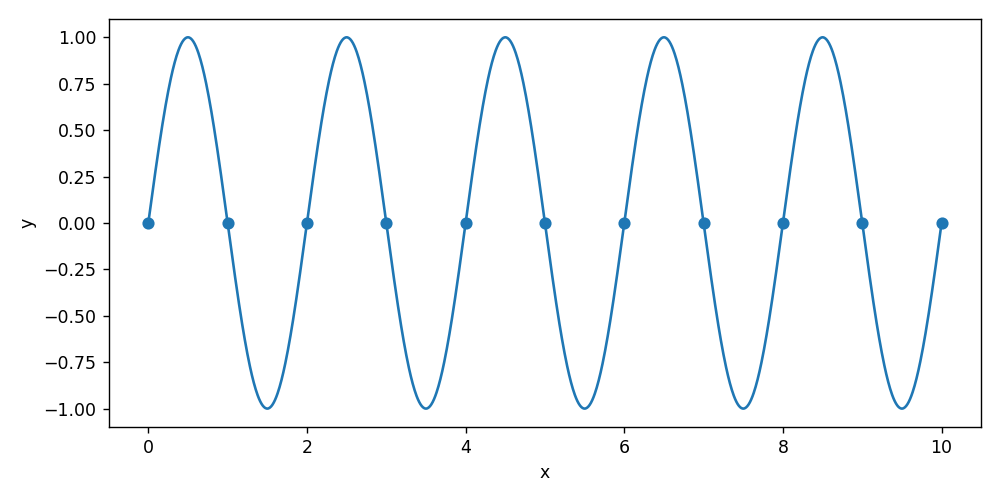

In [7]:
x = np.linspace(0,10,11) # complete
y = gen_periodic_data(x,period=2) #period=1/f=1/(1/2) # complete
x_signal = np.linspace(0,10,1234) # complete
y_signal = gen_periodic_data(x_signal,period=2) # complete
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x,y)
ax.plot(x_signal, y_signal)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

Sampling a signal directly at the Nyquist frequency results in a lack of any variability. But does this just mean that $f_\mathrm{Ny}$ is special? What happens at $f > f_\mathrm{Ny}$?

**Problem 2b**

As above, generate and plot a periodic signal with $f = 0.7$ on an even grid from 0 to 10. Overplot the underlying signal in addition to the observations.

<IPython.core.display.Javascript object>


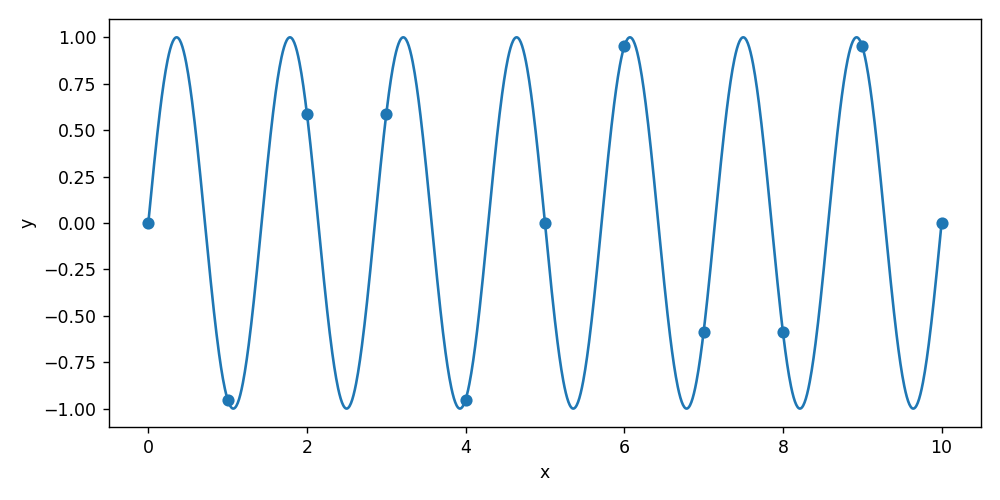

In [8]:
x = np.linspace(0,10,11) # complete
y = gen_periodic_data(x,period=1./0.7) # complete
x_signal = np.linspace(0,10,1234)# complete
y_signal = gen_periodic_data(x_signal,period=1./0.7)# complete
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x,y)
ax.plot(x_signal, y_signal)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

From the plot the signal is clearly variable (unlike when $f = f_\mathrm{Ny}$). However, there are fewer than 2 observations per cycle.

**Problem 2c**

Overplot a source with $f = 2.7$ on the same data shown in **2b**.

<IPython.core.display.Javascript object>


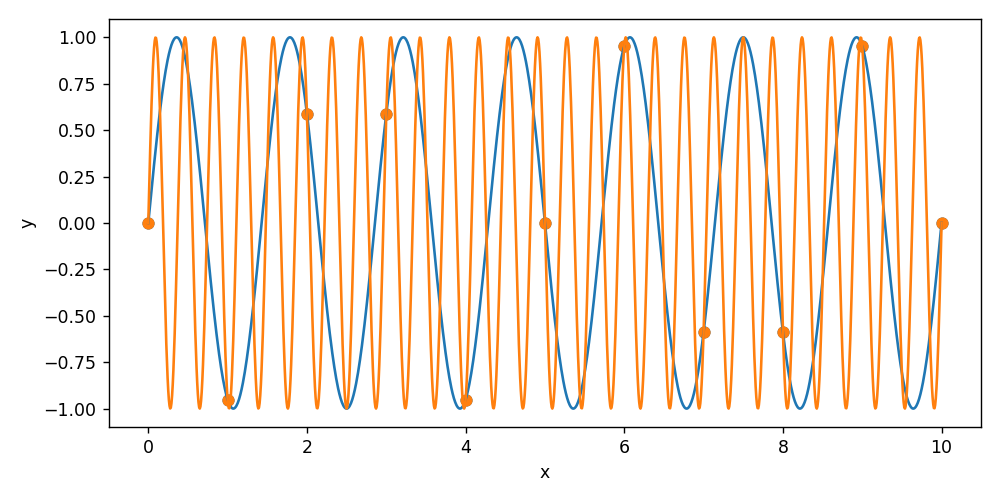

In [9]:
x = np.linspace(0,10,11)# complete
y = gen_periodic_data(x,period=1/0.7) # complete
x_signal = np.linspace(0,10,1234) # complete
y_signal = gen_periodic_data(x_signal,period=1/0.7) # complete
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x,y)
ax.plot(x_signal, y_signal)

y_high = gen_periodic_data(x,period=1/2.7) # complete
y_signal_high = gen_periodic_data(x_signal,period=1/2.7) # complete
ax.scatter(x,y_high)
ax.plot(x_signal, y_signal_high)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

The observations are identical! Here is what you need to remember about the Nyquist frequency:

  1. If you are going to obtain observations at *regular intervals*, and there is a specific signal you wish to detect, then be sure to sample the data such that $f_\mathrm{Ny} > f_\mathrm{signal}$.

  2. For all $f > f_\mathrm{Ny}$, $f$ will be aliased with $f \pm 2n f_\mathrm{Ny}$ signals, where $n$ is an integer. Practically speaking, this means it does not make sense to search for signals with $f > f_\mathrm{Ny}$.

  3. Finally, (and this is something that is often wrong in the literature) there is no Nyquist limit for unevenly sampled data (see VanderPlas 2017 for further details). Thus, for (virtually all) ground-based observing one need not worry about the Nyquist limit.

Staying on the topic of non-continuous observations, I present without derivation the discrete Fourier transform:

$$ \hat g_\mathrm{obs}(f) = \sum_{n = 0}^N g_n\,e^{-2\pi i f n\Delta t}$$

where $g_n = g(n\Delta t)$, and $\Delta t$ is the sampling interval. Our discussion of the Nyquist frequency tells us that we cannot detect frequencies $f > 1/2\Delta T$. Thus, the relevant frequencies to search for power given $\Delta t$ are between 0 and $f_\mathrm{Ny}$, which we can sample on a grid $\Delta f = 1/(N \Delta t)$. 

From there:

$$\hat g_k = \sum_{n = 0}^N g_n\,e^{-2\pi i f knN}$$

where $\hat g_k = \hat g_\mathrm{obs} (k\Delta f)$. This is the discrete Fourier transform. 

I said a full derivation will not be provided, and that is true. To understand how we went from a continuous integral to the summation above, recall that regular observations of a continous signal over a finite interval is equivalent to multiplying the continuous signal by a Dirac comb function and a window function. The delta functions from the Dirac comb function collapse the integral to a sum, while the window function limits that sum from $0$ to $N$.

From the discrete Fourier transform we can then calculate the periodogram (an estimator of the power spectrum):

$$\mathcal{P}(f) = \frac{1}{N}\left|\sum_{n=1}^{N} g_n\,e^{-2\pi i f knN}\right|^2$$

which is also called the classical periodogram or the Schuster periodogram (Schuster 1898). 

## Problem 3) The LS Periodogram

Ultimately, we care about applications where the data are not perfectly uniformly sampled (even *Kepler* data is not uniformly sampled).

 We can re-write the classical periodogram as:

$$\mathcal{P}(f) = \frac{1}{N}\left|\sum_{n=1}^{N} g_n\,e^{-2\pi i f t_n}\right|^2$$

where $t_n$ corresponds to the observation times. Irregular sampling removes a lot of the nice statistical properties of the discrete Fourier transform. Scargle (1982) was able to address these issues via a generalized form of the periodogram. 

[Full disclosure - I'm just skipping the derivation in this case]

Instead, I will simplify things slightly by using the fact that Scargle's modified periodogram is identical to the result one obtains by fitting a sinusoid model to the data at each frequency $f$ and constructing a "periodogram" from the corresponding $\chi^2$ values at each frequency $f$ [this was considered in great detail by Lomb (1976)].

*Note* - to this day I find this particular identity remarkable.

Thus, using the model:

$$y(t;f) = A_f \sin(2\pi f(t - \phi_f))$$

we can calculate the $\chi^2$ for every frequency $f$:

$$\chi^2 = \sum_n (y_n - y(t_n; f))^2$$



The "best" model for a given frequency requires the selection of $A_f$ and $\phi_f$ that minimizes $\chi^2$, which we will call $\hat \chi^2$. Scargle (1982) then showed that the Lomb-Scargle periodogram can be written 

$$\mathcal{P}_\mathrm{LS}(f) = \frac{1}{2}\left[ \hat \chi^2_0 - \hat \chi^2(f) \right]$$

where $\hat \chi^2_0$ is the value for a non-varying reference model.

This realization further enables the inclusion of observational uncertainty in the periodogram, via a familiar adjustment to the $\chi^2$ value:

$$\chi^2 = \sum_n \left(\frac{y_n - y(t_n; f)}{\sigma_n}\right)^2$$

where $\sigma_n$ is the uncertainty on the each measurement, $y_n$. 

Now we will construct a Lomb-Scargle periodogram.

**Problem 3a**

Write a function, `chi2`, to calculate the $\chi^2$ given $f$, $A_f$, and $\phi$, for observations $y_n$ with uncertainty $\sigma_{y,n}$ taken at times $t_n$.

*Hint* - store $A_f$ and $\phi$ in a single variable `theta`, where `a = theta[0]` and `phi = theta[1]` (for later)

In [20]:
def chi2(theta, y, y_unc, x, f):
    a = theta[0]
    phi = theta[1]
    return np.sum(((y - a*np.sin(2*np.pi*f*(x-phi)))/y_unc)**2)

**Problem 3b**

Write a function to minimize the $\chi^2$ given everything but $A_f$ and $\phi_f$.

*Hint* - [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) within the `scipy` package is helpful.

In [21]:
from scipy.optimize import minimize

def min_chi2(theta, y, y_unc, x, f):
    # theta: data that can be varied
    res = minimize(chi2, theta, args=(y,y_unc,x,f)) # complete
    return res.fun

**Problem 3c**

Write a function, `ls_periodogram`, to calculate the LS periodogram for observations $y$, $\sigma_y$, $t$ over a frequency grid `f_grid`.

In [22]:
def ls_periodogram(y, y_unc, x, f_grid):
    psd    = np.empty_like(f_grid)
    chi2_0 = np.sum(((y - np.mean(y))/y_unc)**2)
    for f_num, f in enumerate(f_grid):
        psd[f_num] = 0.5*(chi2_0 - min_chi2([0,0], y, y_unc, x, f))
    
    return psd

**Problem 3d**

Generate a periodic signal with 100 observations taken at random intervals over a time period of 10 days. Use an input period of 5.25, amplitude of 7.4, and variance of the noise = 0.8. Then compute and plot the periodogram for the simulated data. Do you recover the simulated period?

*Hint* - set the minimum frequency in the grid to $1/T$ where $T$ is the duration of the observations. Set the maximum frequnecy to 10, and use an equally spaced grid with 50 points. 

In [25]:
np.random.seed(185)
# calculate the periodogram

x = 10*np.random.rand(100)
y = gen_periodic_data(x, period=5.25, amplitude=7.4, noise=0.8)
y_unc = np.ones_like(x)*np.sqrt(0.8)

f_grid = np.linspace(1/np.ptp(x),10,50) # complete

psd_ls = ls_periodogram(y, y_unc, x, f_grid)

<IPython.core.display.Javascript object>


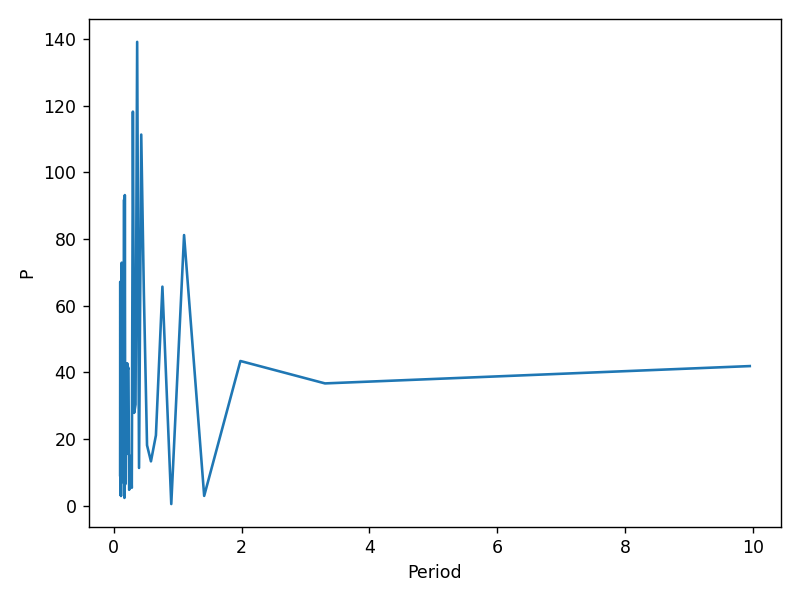

In [26]:
# plot the periodogram
fig, ax = plt.subplots()
ax.plot(1/f_grid, psd_ls)
ax.set_ylabel('P')
ax.set_xlabel('Period')
fig.tight_layout()

In [ ]:
stop

**Problem 3e**

For the same data, include 1000 points in `f_grid` and calculate and plot the periodogram. 

Now do you recover the correct period?

In [27]:
# calculate the periodogram
f_grid = np.linspace(1/np.ptp(x),10,1000) # complete

psd_ls = ls_periodogram(y, y_unc, x, f_grid)

<IPython.core.display.Javascript object>


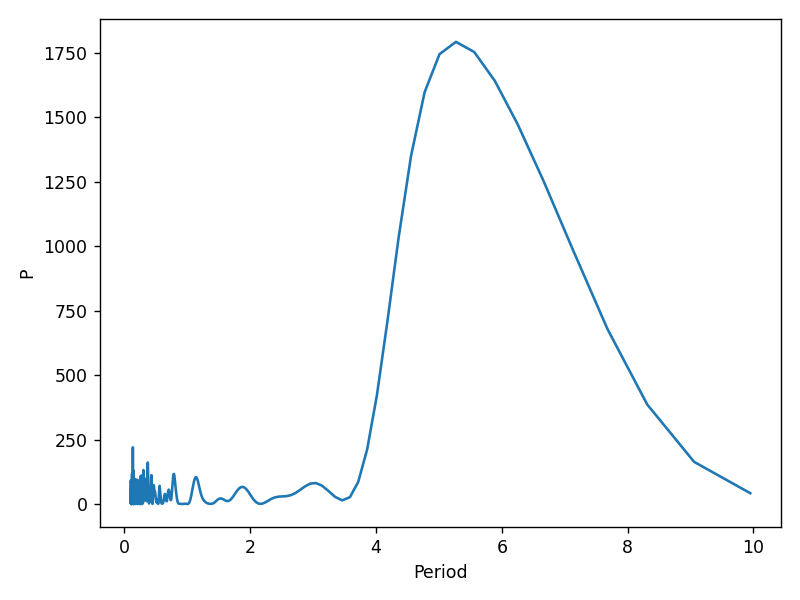

The best fit period is: 5.2722


In [28]:
# plot the periodogram
fig,ax = plt.subplots()

ax.plot(1/f_grid, psd_ls)
ax.set_ylabel('P')
ax.set_xlabel('Period')
fig.tight_layout()

print("The best fit period is: {:.4f}".format(1/f_grid[np.argmax(psd_ls)]))

**Problem 3f**

Plot the phase-folded data at the newly found "best" fit period.

<IPython.core.display.Javascript object>


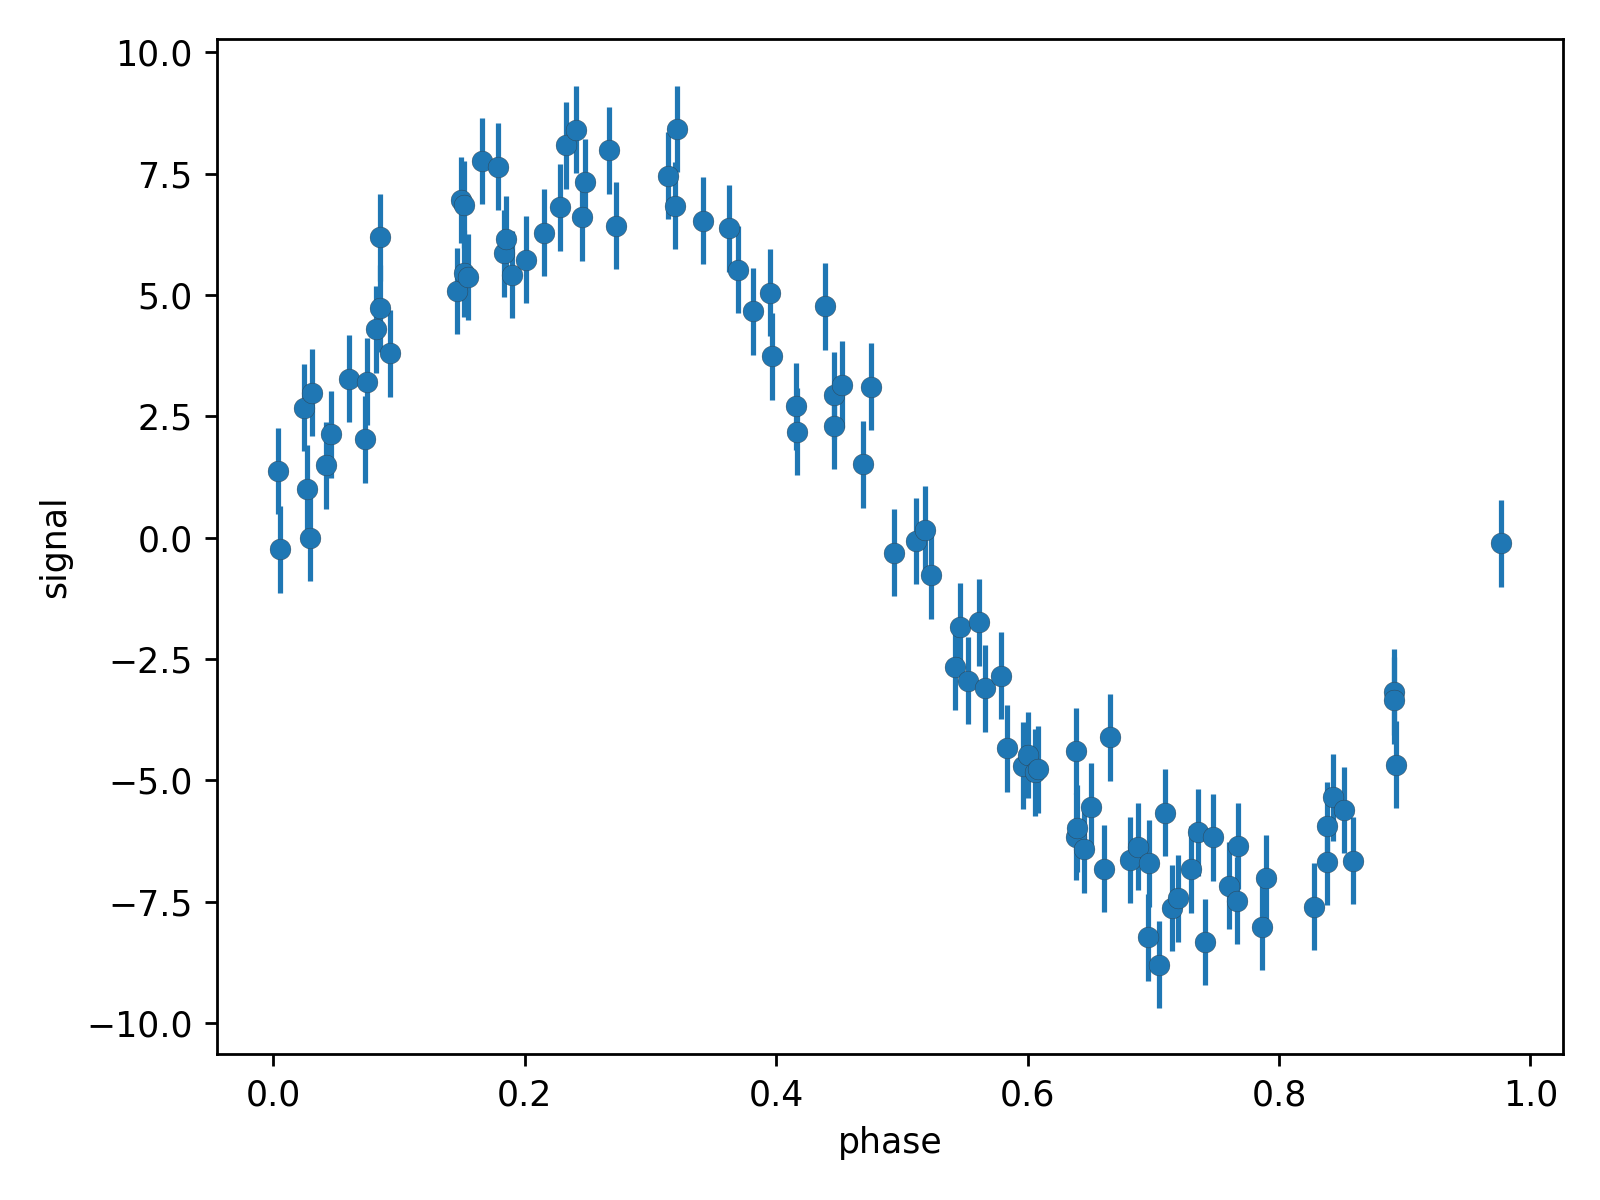

In [29]:
new_period=1/f_grid[np.argmax(psd_ls)]
phase_plot(x,y,new_period,y_unc) # complete

### Congratulations

You did it! You just developed the software necessary to find periodic signals in sparsely sampled, noisy data.

You are ready to conquer LSST.

**But wait!**

There should be a few things that are bothering you. 

First and foremost, why did we use a grid with 50 points and then increase that to 1000 points for the previous simulation?

There are many important ramifications following the choice of an evaluation grid for the LS periodogram. When selecting the grid upon which to evaluate $f$ one must determine both the limits for the grid and the spacing within the grid. 

The minimum frequency is straightforward: $f_\mathrm{min} = 1/T$ corresponds to a signal that experiences 1 cycle in the span of the data. Computationally, $f_\mathrm{min} = 0$ does not add much time. 

The maximum frequency is straightforward (**if** you have evenly spaced data): $f_\mathrm{Ny}$. 

What if the data are not evenly spaced (a situation for which we said $f_\mathrm{Ny}$ does not exist? 

There are many ad-hoc methods in the literature, such as $f_\mathrm{max} = 1/<\Delta T>$, where $<\Delta T>$ is the mean separation of consecutive observations. Again - this is *not* correct.

[VanderPlas (2017)](https://arxiv.org/abs/1703.09824) discusses this in detail. 

My useful practical advice is to set $f_\mathrm{max}$ to the maximum frequency that you might expect to see in the data (for example, with the exception of a few extreme white dwarf systems, essentially no stars show periodicity at $< 1\,\mathrm{hr}$).

Of course, we still haven't decided what grid to adopt. If we use too few points, we will not resolve the peak in the periodogram. Alternatively, if we include too many points in the grid we will waste a lot of computation. 

Fortunately, we can determine $\Delta f$ based on the window function (i.e., duration of the observations). The Fourier transform of a window function of length $T$ produces a sinc signal with width $\sim 1/T$. Thus, we need $\Delta f$ to sample $\sim 1/T$, which means $\Delta f = 1/n_0T$, where $n_0$ is a constant, and 5 is a good choice for $n_0$.

**Problem 3g**

Calculate the optimal frequency grid for Rubin light curves. Assume time is measured in days, a survey duration of 10 years and that the observations cannot recover periods less than 1 hr. 

What is the size of this frequency grid?

In [30]:
f_min =  1/(10*365) # 1/(10 years * 365 d/year)
f_max = 1/(1/24)# complete
delta_f = f_min/5# complete

f_grid = np.arange(f_min, f_max, delta_f)

print("{:d} grid points are needed to sample the periodogram".format(len(f_grid)))

437995 grid points are needed to sample the periodogram


## Code from [PracticalLombScargle](https://github.com/jakevdp/PracticalLombScargle/) by Jake Van der Plas

The functions below implement plotting routines developed by Jake to illustrate some properties of Fourier transforms. 

This code is distributed under a BSD-3 licence, which is repeated below: 

Copyright (c) 2015, Jake Vanderplas
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of PracticalLombScargle nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [31]:
def fourier_pairs_plot():
    
    fig, ax = plt.subplots(4, 2, figsize=(10, 6))
    fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.95,
                        hspace=0.3, wspace=0.2)

    x = np.linspace(-5, 5, 1000)

    for axi in ax.flat:
        axi.xaxis.set_major_formatter(plt.NullFormatter())
        axi.yaxis.set_major_formatter(plt.NullFormatter())

        # draw center line
        axi.axvline(0, linestyle='dotted', color='gray')
        axi.axhline(0, linestyle='dotted', color='gray')

    style_re = dict(linestyle='solid', color='k', linewidth=2)
    style_im = dict(linestyle='solid', color='gray', linewidth=2)
    text_style = dict(size=14, color='gray')


    # sine -> delta
    ax[0, 0].plot(x, np.cos(x),**style_re)
    ax[0, 0].set(xlim=(-5, 5), ylim=(-1.2, 1.2))
    ax[0, 0].annotate('', (-np.pi, 0), (np.pi, 0),
                      arrowprops=dict(arrowstyle='|-|', color='gray'))
    ax[0, 0].text(0, 0, '$1/f_0$', ha='center', va='bottom', **text_style)
    ax[0, 0].set_title('Sinusoid')

    ax[0, 1].plot([-5, 2, 2, 2, 5], [0, 0, 1, 0, 0], **style_re)
    ax[0, 1].plot([-5, -2, -2, -2, 5], [0, 0, 1, 0, 0], **style_re)
    ax[0, 1].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[0, 1].annotate('', (0, 0.4), (2, 0.4), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[0, 1].annotate('', (0, 0.4), (-2, 0.4), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[0, 1].text(1, 0.45, '$+f_0$', ha='center', va='bottom', **text_style)
    ax[0, 1].text(-1, 0.45, '$-f_0$', ha='center', va='bottom', **text_style)
    ax[0, 1].set_title('Delta Functions')

    # gaussian -> gaussian
    ax[1, 0].plot(x, np.exp(-(2 * x) ** 2), **style_re)
    ax[1, 0].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[1, 0].annotate('', (0, 0.35), (0.6, 0.35), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[1, 0].text(0, 0.4, '$\sigma$', ha='center', va='bottom', **text_style)
    ax[1, 0].set_title('Gaussian')

    ax[1, 1].plot(x, np.exp(-(x / 2) ** 2), **style_re)
    ax[1, 1].set(xlim=(-5, 5), ylim=(-0.2, 1.2))
    ax[1, 1].annotate('', (0, 0.35), (2, 0.35), arrowprops=dict(arrowstyle='<-', color='gray'))
    ax[1, 1].text(0, 0.4, '$(2\pi\sigma)^{-1}$', ha='center', va='bottom', **text_style)
    ax[1, 1].set_title('Gaussian')

    # top hat -> sinc
    ax[2, 0].plot([-2, -1, -1, 1, 1, 2], [0, 0, 1, 1, 0, 0], **style_re)
    ax[2, 0].set(xlim=(-2, 2), ylim=(-0.3, 1.2))
    ax[2, 0].annotate('', (-1, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[2, 0].text(0.0, 0.5, '$T$', ha='center', va='bottom', **text_style)
    ax[2, 0].set_title('Top Hat')

    ax[2, 1].plot(x, np.sinc(x), **style_re)
    ax[2, 1].set(xlim=(-5, 5), ylim=(-0.3, 1.2))
    ax[2, 1].annotate('', (-1, 0), (1, 0), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[2, 1].text(0.0, 0.0, '$2/T$', ha='center', va='bottom', **text_style)
    ax[2, 1].set_title('Sinc')

    # comb -> comb
    ax[3, 0].plot([-5.5] + sum((3 * [i] for i in range(-5, 6)), []) + [5.5],
                  [0] + 11 * [0, 1, 0] + [0], **style_re)
    ax[3, 0].set(xlim=(-5.5, 5.5), ylim=(-0.2, 1.2))
    ax[3, 0].annotate('', (0, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[3, 0].text(0.5, 0.6, '$T$', ha='center', va='bottom', **text_style)
    ax[3, 0].set_title('Dirac Comb')

    ax[3, 1].plot([-5.5] + sum((3 * [i] for i in range(-5, 6)), []) + [5.5],
                  [0] + 11 * [0, 1, 0] + [0], **style_re)
    ax[3, 1].set(xlim=(-2.5, 2.5), ylim=(-0.2, 1.2));
    ax[3, 1].annotate('', (0, 0.5), (1, 0.5), arrowprops=dict(arrowstyle='<->', color='gray'))
    ax[3, 1].text(0.5, 0.6, '$1/T$', ha='center', va='bottom', **text_style)
    ax[3, 1].set_title('Dirac Comb')

    for i, letter in enumerate('abcd'):
        ax[i, 0].set_ylabel('({0})'.format(letter), rotation=0)

    # Draw arrows between pairs of axes
    for i in range(4):
        left = ax[i, 0].bbox.transformed(fig.transFigure.inverted()).bounds
        right = ax[i, 1].bbox.transformed(fig.transFigure.inverted()).bounds
        x = 0.5 * (left[0] + left[2] + right[0])
        y = left[1] + 0.5 * left[3]
        fig.text(x, y, r'$\Longleftrightarrow$',
                 ha='center', va='center', size=30)